In [ ]:
# @title Copyright & License (click to expand)
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI Pipelines with KFP 2.x

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/pipelines/kfp2_pipeline.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/pipelines/kfp2_pipeline.ipynb">
        <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
    <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/official/pipelines/kfp2_pipeline.ipynb">
       <img src="https://www.gstatic.com/cloud/images/navigation/vertex-ai.svg" alt="Vertex AI logo">Open in Vertex AI Workbench
    </a>
</table>

## Overview

This tutorial demonstrates how to use the Vertex AI Pipelines with KFP 2.x.

Learn more about Vertex AI Pipelines.

### Objective

In this tutorial, you learn to use `Vertex AI Pipelines` and KFP 2.x version of `Google Cloud Pipeline Components` to train and deploy an XGBoost model.


This tutorial uses the following Google Cloud ML services:

- `Vertex AI Pipelines`
- `Google Cloud Pipeline Components`
- `BigQuery`


The steps performed include:

- Create a KFP pipeline:
    - Create a `BigQuery Dataset` resource.
    - Export the dataset.
    - Train an XGBoost `Model` resource.
    - Create an `Endpoint` resource.
    - Deploys the `Model` resource to the `Endpoint` resource.
- Compile the KFP pipeline.
- Execute the KFP pipeline using `Vertex AI Pipelines`

The components are [documented here](https://google-cloud-pipeline-components.readthedocs.io/en/latest/google_cloud_pipeline_components.aiplatform.html#module-google_cloud_pipeline_components.aiplatform).

### Dataset

The [Census Income Data Set](https://archive.ics.uci.edu/ml/datasets/Census+Income) that this notebook uses for training is available publicly at the BigQuery location `bigquery-public-data.ml_datasets.census_adult_income`. It consists of the following fields:

- `age`: Age.
- `workclass`: Nature of employment.
- `functional_weight`: Sample weight of the individual from the original Census data. How likely they were to be included in this dataset, based on their demographic characteristics vs. whole-population estimates.
- `education`: Level of education completed.
- `education_num`: Estimated years of education completed based on the value of the education field.
- `marital_status`: Marital status.
- `occupation`: Occupation category.
- `relationship`: Relationship to the household.
- `race`: Race.
- `sex`: Gender.
- `capital_gain`: Amount of capital gains.
- `capital_loss`: Amount of capital loss.
- `hours_per_week`: Hours worked per week.
- `native_country`: Country of birth.
- `income_bracket`: Either " >50K" or " <=50K" based on income.

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* BigQuery
* Cloud Storage

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing), [BigQuery pricing](https://cloud.google.com/bigquery/pricing), [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Installation

Install the following packages required to execute this notebook.

In [ ]:
! pip3 install --no-cache-dir --upgrade "kfp>2" \
                                        google-cloud-aiplatform

### Colab only: Uncomment the following cell to restart the kernel

In [ ]:
# Automatically restart kernel after installs so that your environment can access the new packages
# import IPython

# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

Check the KFP SDK version.

In [ ]:
! python3 -c "import kfp; print('KFP SDK version: {}'.format(kfp.__version__))"
! pip3 freeze | grep aiplatform

## Before you begin

### Set your project ID

**If you don't know your project ID**, try the following:
* Run `gcloud config list`.
* Run `gcloud projects list`.
* See the support page: [Locate the project ID](https://support.google.com/googleapi/answer/7014113)

In [ ]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID}

#### Region

You can also change the `REGION` variable used by Vertex AI. Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [ ]:
REGION = "us-central1"
BQ_REGION = REGION.split("-")[0].upper()

### Authenticate your Google Cloud account

Depending on your Jupyter environment, you may have to manually authenticate. Follow the relevant instructions below.

**1. Vertex AI Workbench**
* Do nothing as you are already authenticated.

**2. Local JupyterLab instance, uncomment and run:**

In [ ]:
# ! gcloud auth login

**3. Colab, uncomment and run:**

In [ ]:
# from google.colab import auth
# auth.authenticate_user()

**4. Service account or other**
* See how to grant Cloud Storage permissions to your service account at https://cloud.google.com/storage/docs/gsutil/commands/iam#ch-examples.

### Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.

In [ ]:
BUCKET_URI = f"gs://your-bucket-name-{PROJECT_ID}-unique"  # @param {type:"string"}

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
! gsutil mb -l $REGION -p $PROJECT_ID $BUCKET_URI

#### Service Account 

You use a service account to create Vertex AI Pipeline jobs.

In [ ]:
SERVICE_ACCOUNT = "[your-service-account]"  # @param {type:"string"}

In [ ]:
import sys

IS_COLAB = "google.colab" in sys.modules
if (
    SERVICE_ACCOUNT == ""
    or SERVICE_ACCOUNT is None
    or SERVICE_ACCOUNT == "[your-service-account]"
):
    # Get your service account from gcloud
    if not IS_COLAB:
        shell_output = !gcloud auth list 2>/dev/null
        SERVICE_ACCOUNT = shell_output[2].replace("*", "").strip()

    else:  # IS_COLAB:
        shell_output = ! gcloud projects describe  $PROJECT_ID
        project_number = shell_output[-1].split(":")[1].strip().replace("'", "")
        SERVICE_ACCOUNT = f"{project_number}-compute@developer.gserviceaccount.com"

    print("Service Account:", SERVICE_ACCOUNT)

#### Set service account access for Vertex AI Pipelines

Run the following commands to grant your service account access to read and write pipeline artifacts in the bucket that you created in the previous step. You only need to run this step once per service account.

In [ ]:
! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectCreator $BUCKET_URI

! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectViewer $BUCKET_URI

### Import libraries and define constants

In [ ]:
import google.cloud.aiplatform as aiplatform
import kfp
from kfp import compiler, dsl
from kfp.dsl import Artifact, Dataset, Input, Metrics, Model, Output, component

## Initialize Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project and corresponding bucket.

In [ ]:
aiplatform.init(project=PROJECT_ID, staging_bucket=BUCKET_URI)

In [ ]:
PATH = %env PATH
%env PATH={PATH}:/home/jupyter/.local/bin


DATASET_ID = "census"  # The Data Set ID where the view sits
VIEW_NAME = "census_data"  # BigQuery view you create for input data

KFP_ENDPOINT = (
    "https://720c5bc00c3d6089-dot-us-central1.pipelines.googleusercontent.com/"
)

PIPELINE_ROOT = f"{BUCKET_URI}/census_pipeline"  # This is where all pipeline artifacts are sent. You'll need to ensure the bucket is created ahead of time
PIPELINE_ROOT
print(f"PIPELINE_ROOT: {PIPELINE_ROOT}")

### Create a BigQuery dataset

Next, you create a BQ dataset for this tutorial.

In [ ]:
# Create a BQ Dataset in the project.
!bq mk --location=$BQ_REGION --dataset $PROJECT_ID:$DATASET_ID

## Define components for the pipeline

Next, you define several components that you use in your pipeline.

### Define create BigQuery dataset component

First, you define a component to create BigQuery dataset view from the public dataset.

In [ ]:
@component(
    packages_to_install=["google-cloud-bigquery==3.10.0"],
)
def create_census_view(
    project_id: str,
    dataset_id: str,
    view_name: str,
):
    """Creates a BigQuery view on `bigquery-public-data.ml_datasets.census_adult_income`.

    Args:
        project_id: The Project ID.
        dataset_id: The BigQuery Dataset ID. Must be pre-created in the project.
        view_name: The BigQuery view name.
    """
    from google.cloud import bigquery

    client = bigquery.Client(project=project_id)

    create_or_replace_view = """
        CREATE OR REPLACE VIEW
        `{dataset_id}`.`{view_name}` AS
        SELECT
          age,
          workclass,
          education,
          education_num,
          marital_status,
          occupation,
          relationship,
          race,
          sex,
          capital_gain,
          capital_loss,
          hours_per_week,
          native_country,
          income_bracket,
        FROM
          `bigquery-public-data.ml_datasets.census_adult_income`
    """.format(
        dataset_id=dataset_id, view_name=view_name
    )

    job_config = bigquery.QueryJobConfig()
    query_job = client.query(query=create_or_replace_view, job_config=job_config)
    query_job.result()

### Define export dataset component

Next, you define a component to export the data from your BigQuery dataset to use for training the model.

In [ ]:
@component(
    packages_to_install=["google-cloud-bigquery[pandas]==3.10.0"],
)
def export_dataset(
    project_id: str,
    dataset_id: str,
    view_name: str,
    dataset: Output[Dataset],
):
    """Exports from BigQuery to a CSV file.

    Args:
        project_id: The Project ID.
        dataset_id: The BigQuery Dataset ID. Must be pre-created in the project.
        view_name: The BigQuery view name.

    Returns:
        dataset: The Dataset artifact with exported CSV file.
    """
    from google.cloud import bigquery

    client = bigquery.Client(project=project_id)

    table_name = f"{project_id}.{dataset_id}.{view_name}"
    query = """
    SELECT
      *
    FROM
      `{table_name}`
    """.format(
        table_name=table_name
    )

    job_config = bigquery.QueryJobConfig()
    query_job = client.query(query=query, job_config=job_config)
    df = query_job.result().to_dataframe()
    df.to_csv(dataset.path, index=False)

### Define XGBoost training component

Next, you define a component to train an XGBoost model with the training data.

In [ ]:
@component(
    packages_to_install=[
        "xgboost==1.6.2",
        "pandas==1.3.5",
        "joblib==1.1.0",
        "scikit-learn==1.0.2",
    ],
)
def xgboost_training(
    dataset: Input[Dataset],
    model: Output[Model],
    metrics: Output[Metrics],
):
    """Trains an XGBoost classifier.

    Args:
        dataset: The training dataset.

    Returns:
        model: The model artifact stores the model.joblib file.
        metrics: The metrics of the trained model.
    """
    import os

    import joblib
    import pandas as pd
    import xgboost as xgb
    from sklearn.metrics import (accuracy_score, precision_recall_curve,
                                 roc_auc_score)
    from sklearn.model_selection import (RandomizedSearchCV, StratifiedKFold,
                                         train_test_split)
    from sklearn.preprocessing import LabelEncoder

    # Load the training census dataset
    with open(dataset.path, "r") as train_data:
        raw_data = pd.read_csv(train_data)

    CATEGORICAL_COLUMNS = (
        "workclass",
        "education",
        "marital_status",
        "occupation",
        "relationship",
        "race",
        "sex",
        "native_country",
    )
    LABEL_COLUMN = "income_bracket"
    POSITIVE_VALUE = " >50K"

    # Convert data in categorical columns to numerical values
    encoders = {col: LabelEncoder() for col in CATEGORICAL_COLUMNS}
    for col in CATEGORICAL_COLUMNS:
        raw_data[col] = encoders[col].fit_transform(raw_data[col])

    X = raw_data.drop([LABEL_COLUMN], axis=1).values
    y = raw_data[LABEL_COLUMN] == POSITIVE_VALUE

    X_train, X_test, y_train, y_test = train_test_split(X, y)
    _ = xgb.DMatrix(X_train, label=y_train)
    _ = xgb.DMatrix(X_test, label=y_test)

    params = {
        "reg_lambda": [0, 1],
        "gamma": [1, 1.5, 2, 2.5, 3],
        "max_depth": [2, 3, 4, 5, 10, 20],
        "learning_rate": [0.1, 0.01],
    }

    xgb_model = xgb.XGBClassifier(
        n_estimators=50,
        objective="binary:hinge",
        silent=True,
        nthread=1,
        eval_metric="auc",
    )

    folds = 5
    param_comb = 20

    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

    random_search = RandomizedSearchCV(
        xgb_model,
        param_distributions=params,
        n_iter=param_comb,
        scoring="precision",
        n_jobs=4,
        cv=skf.split(X_train, y_train),
        verbose=4,
        random_state=42,
    )

    random_search.fit(X_train, y_train)
    xgb_model_best = random_search.best_estimator_
    predictions = xgb_model_best.predict(X_test)
    score = accuracy_score(y_test, predictions)
    auc = roc_auc_score(y_test, predictions)
    _ = precision_recall_curve(y_test, predictions)

    metrics.log_metric("accuracy", (score * 100.0))
    metrics.log_metric("framework", "xgboost")
    metrics.log_metric("dataset_size", len(raw_data))
    metrics.log_metric("AUC", auc)

    # Export the model to a file
    os.makedirs(model.path, exist_ok=True)
    joblib.dump(xgb_model_best, os.path.join(model.path, "model.joblib"))

### Define deploying the model component

Finally, you define a component to deploy the XGBoost model.

In [ ]:
@component(
    packages_to_install=["google-cloud-aiplatform==1.25.0"],
)
def deploy_xgboost_model(
    model: Input[Model],
    project_id: str,
    vertex_endpoint: Output[Artifact],
    vertex_model: Output[Model],
):
    """Deploys an XGBoost model to Vertex AI Endpoint.

    Args:
        model: The model to deploy.
        project_id: The project ID of the Vertex AI Endpoint.

    Returns:
        vertex_endpoint: The deployed Vertex AI Endpoint.
        vertex_model: The deployed Vertex AI Model.
    """
    from google.cloud import aiplatform

    aiplatform.init(project=project_id)

    deployed_model = aiplatform.Model.upload(
        display_name="census-demo-model",
        artifact_uri=model.uri,
        serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.1-6:latest",
    )
    endpoint = deployed_model.deploy(machine_type="n1-standard-4")

    vertex_endpoint.uri = endpoint.resource_name
    vertex_model.uri = deployed_model.resource_name

## Construct the XGBoost training pipeline

Now you define the pipeline, with the following steps:

- Create a BigQuery view of the dataset.
- Export the dataset.
- Train the model.
- Deploy the model.

In [ ]:
@dsl.pipeline(
    name="census-demo-pipeline",
)
def pipeline():
    """A demo pipeline."""

    create_input_view_task = create_census_view(
        project_id=PROJECT_ID,
        dataset_id=DATASET_ID,
        view_name=VIEW_NAME,
    )

    export_dataset_task = (
        export_dataset(
            project_id=PROJECT_ID,
            dataset_id=DATASET_ID,
            view_name=VIEW_NAME,
        )
        .after(create_input_view_task)
        .set_caching_options(False)
    )

    training_task = xgboost_training(
        dataset=export_dataset_task.outputs["dataset"],
    )

    _ = deploy_xgboost_model(
        project_id=PROJECT_ID,
        model=training_task.outputs["model"],
    )

### Compile the pipeline

Next, you compile the pipeline. 

In [ ]:
compiler.Compiler().compile(pipeline_func=pipeline, package_path="pipeline.yaml")

### Run the pipeline using Vertex AI Pipelines

Now, run the compiled pipeline.

In [ ]:
job = aiplatform.PipelineJob(
    display_name="census-demo-pipeline",
    template_path="pipeline.yaml",
    pipeline_root=PIPELINE_ROOT,
)

job.run()

### Run the pipeline using KFP

Alternatively, you can run the pipeline using KFP directly.

*Note:* You need to provider their own value for `KFP_ENDPOINT`

In [ ]:
try:
    KFP_ENDPOINT = "[your-kfp-endpoint]"

    client = kfp.Client(
        host=KFP_ENDPOINT,
    )

    client.create_run_from_pipeline_package(
        pipeline_file="pipeline.yaml",
        pipeline_root=PIPELINE_ROOT,
        run_name="census-demo-pipeline",
    )
except Exception as e:
    print(e)

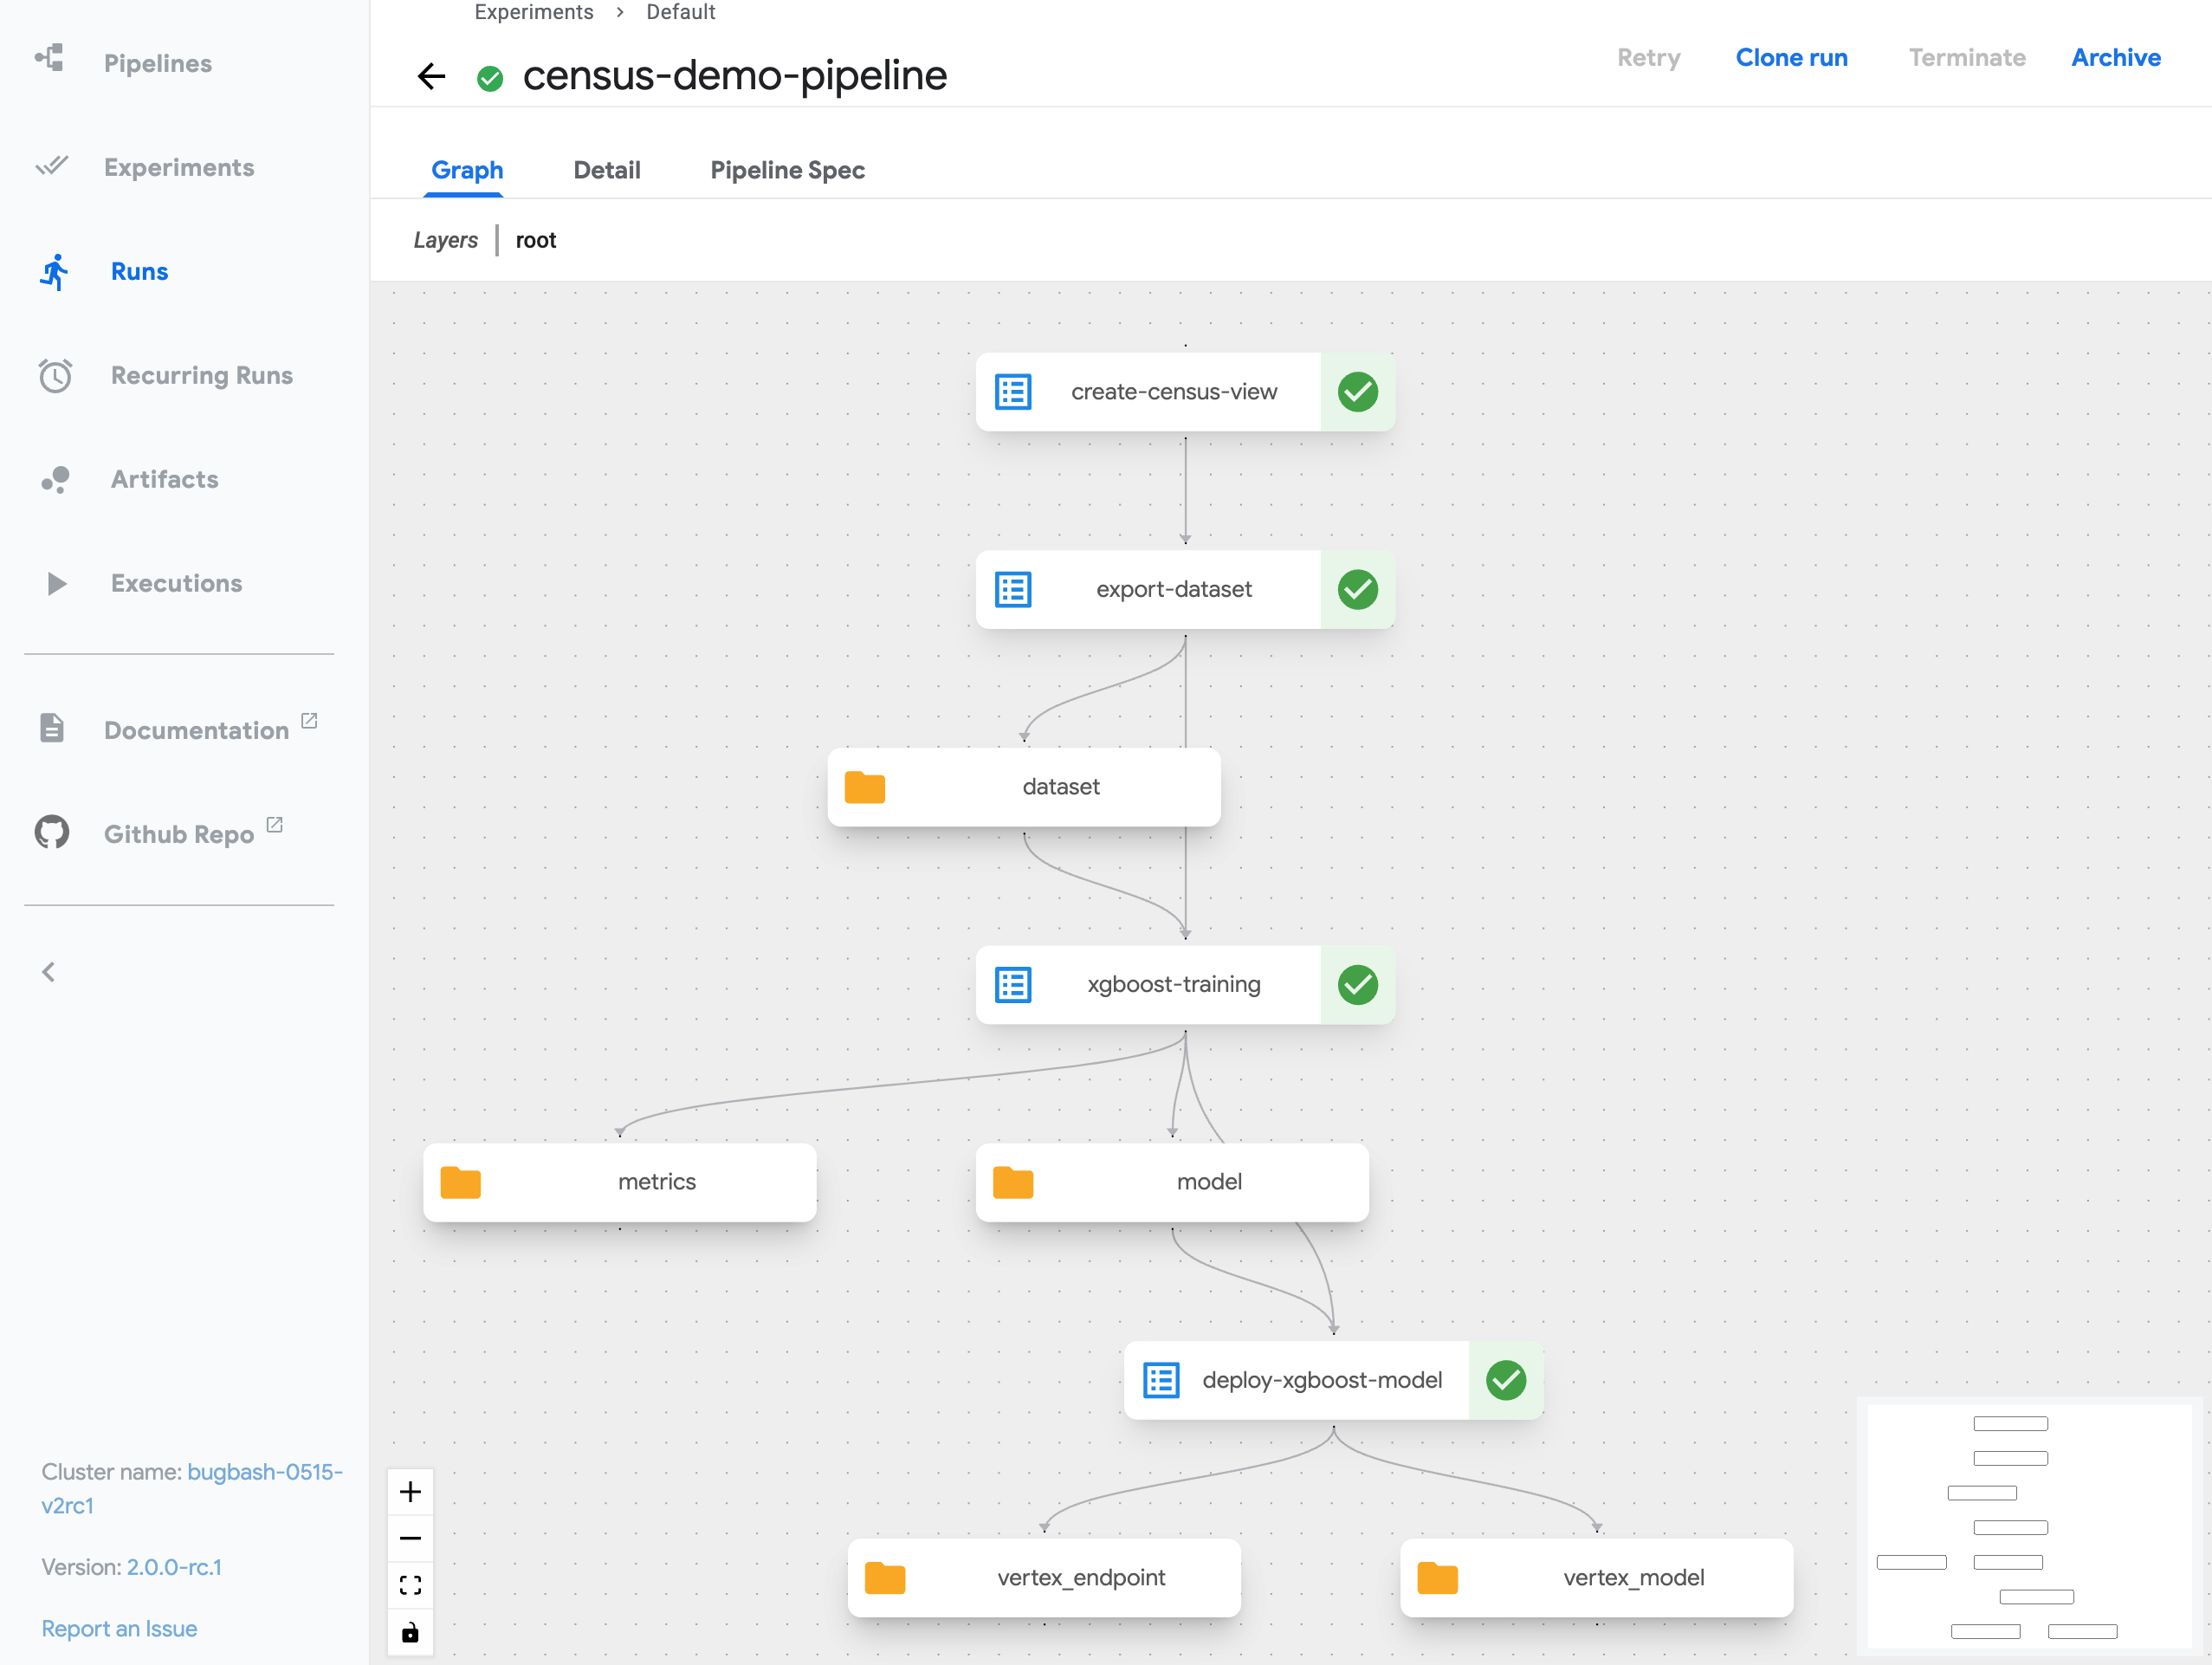

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

In [ ]:
delete_bucket = True

job.delete()

if delete_bucket or os.getenv("ID_TESTING"):
    ! gsutil rm -rf {BUCKET_URI}